# **Exercise 5**: Model scenario analysis

In this exercises we will do a scenario analysis with the model created with notebook 01.
We will update the sea level boundary condition to simulate the effect of sea level rise on flood risk in Savannah.
You can use this notebook as template to run other scenario analyses to e.g. assess the effect of adaptation measures, land use changes, or future climate conditions.

The steps to do so are:
- Step 1: Read the model a change the output root folder to a new directory
- Step 2: Update the model and save it. This can be the sea level boundary condition, or any other model parameter you want to change.
- Step 3: Run the model again
- Step 4: Inspect the differences in the results (flood extent, flood depth, etc.)

## **Step 0:** Import dependencies

Before anything else we need to import the required packages

In [1]:
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import hydromt
from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel

# local script
from sfincs_utils import run_sfincs

## **Step 1:** Read the model a change the output root
Now let's copy our old model to a new folder, so we can always look at the old model later on:

In [2]:
model_root_old = '..\models\sfincs_savannah_T100'
model_root_new = '..\models\sfincs_savannah_T100_slr_levees'

# initialize the old model again with a logger and the data catalog
# but now in read-only mode
logger = setuplog("SFINCS_log_savannah", log_level=20)
sf = SfincsModel(root=model_root_old, mode="r", logger=logger)
sf.read()

# change the model root (to not overwrite existing model)
# it is recommended to use a different root_folder for each model run
# make sure to keep your folders well organized
# NOTE that this does not copy any data, it just points to a new location where the model will be saved later
sf.set_root(model_root_new, mode="w+")

2026-01-30 10:32:11,024 - SFINCS_log_savannah - log - INFO - HydroMT version: 0.10.1
2026-01-30 10:32:11,065 - SFINCS_log_savannah - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.2.1).
2026-01-30 10:32:11,080 - SFINCS_log_savannah - sfincs - WARNING - depfile not found at c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah_T100\sfincs.dep
2026-01-30 10:32:17,798 - SFINCS_log_savannah - sfincs - WARNING - Index in bndfile does not match c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah_T100\gis\bnd.geojson
2026-01-30 10:32:17,807 - SFINCS_log_savannah - sfincs - WARNING - Index in bndfile does not match c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah_T100\gis\bnd.geojson
2026-01-30 10:32:17,810 - SFINCS_log_savannah - sfincs - INFO - Model read


## **Step 2:** Update forcing

Now we will update the forcing of the model. We will use the same forcing as in the previous exercise, but will now add an offset to the water levels to simulate sea level rise.

Note that the index attribute of the locations matches with the column names of the timeseries file. This is important for HydroMT to know which timeseries belongs to which location!

In [3]:
# read  location
locations = gpd.read_file(
    Path(r"../data/gtsm_codec_reanalysis_hourly_v1/gauging_location.geojson")
)
locations = locations.set_index('id')
locations

,geometry
id,
8670870,POINT (-80.9046 32.035)
8720218,POINT (-81.42833 30.3983)


In [4]:
# read design hydrographs
timeseries = pd.read_csv(
    Path(r"../data/water_levels/sim_timeseries_T100.csv"),
    index_col=0,
    parse_dates=True,
)
# clip to model event period
tstart, tstop = sf.get_model_time()
timeseries = timeseries.loc[tstart:tstop]
timeseries.iloc[[0, 1, -2, -1], :]

,8670870,8720218
time,,
2021-01-01 12:00:00,0.74,0.74
2021-01-01 13:00:00,0.73,0.73
2021-01-14 23:00:00,0.96,0.87
2021-01-15 00:00:00,0.93,0.84


In [5]:
# estimate the sea level rise in 2100
# hint use the IPCC AR6 interactive atlas via https://interactive-atlas.ipcc.ch/regional-information
# select the right variable, period en scenario, then click on the region of interest to get the a graph or table from which you can estimate the sea level rise
slr = 1 # [m] FILL IN YOUR ESTIMATE HERE

timeseries_slr = timeseries.copy()
# change the event period to 2100
timeseries_slr.index = (
    timeseries.index - timeseries.index[0] + pd.Timestamp("2100-01-01")
)
# add sea level rise to the timeseries
timeseries_slr = timeseries_slr + slr

2026-01-30 10:32:21,943 - SFINCS_log_savannah - model_api - WARNING - Replacing forcing: bzs
2026-01-30 10:32:22,012 - SFINCS_log_savannah - data_catalog - INFO - Reading data catalog artifact_data latest
2026-01-30 10:32:22,014 - SFINCS_log_savannah - data_catalog - INFO - Parsing data catalog from C:\Users\sanne\.hydromt_data\artifact_data\v0.0.9\data_catalog.yml
2026-01-30 10:32:22,569 - SFINCS_log_savannah - geodataframe - INFO - Reading  vector data from ../data_processed/levees_and_weirs.geojson
No structures file found at: c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah_T100_slr_levees\sfincs.weir

All files in model directory:
figs
gis
hydromt.log


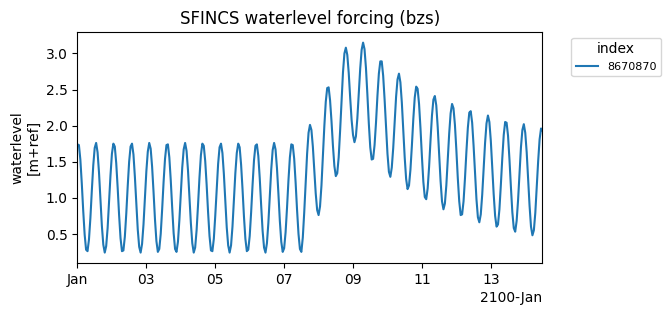

In [6]:
# we need to update the model event time to the new period
# which we can do based on the timeseries index
sf.setup_config(
    tref=timeseries_slr.index[0].to_pydatetime(),
    tstart=timeseries_slr.index[0].to_pydatetime(),
    tstop=timeseries_slr.index[-1].to_pydatetime(),
)

# this time we provide the locations and timeseries as
# pandas / geopandas objects instead of the data catalog keys
sf.setup_waterlevel_forcing(
    locations=locations,
    timeseries=timeseries_slr,
    merge=False,
    # use a large buffer to include all points if the following error is raised
    # ValueError: The gdf_locs index and df_ts columns must be the same
    buffer=1e5,  # buffer from model boundary [m]
)

sf.setup_structures(
        structures="../data_processed/levees_and_weirs.geojson",
        stype='weir',
        dz=5,
        merge=True)

sf.plot_forcing("forcing.png")

# gdf = gpd.read_file("../data_processed/levees_plus.geojson")

# sf.setup_structures(
#     structures=gdf,
#     stype='weir',
#     dz=5,
#     merge=True
# )
# sf.setup_structures(
#         structures="../data_processed/levee_1.geojson",
#         stype='weir',
#         dz=5,
#         merge=True)

# sf.setup_structures(
#         structures="../data_processed/levee_2.geojson",
#         stype='weir',
#         dz=5,
#         merge=True)

from pathlib import Path

# Check if structures file exists
structures_file = Path(sf.root) / "sfincs.weir"

if structures_file.exists():
    # Read as text file (SFINCS format)
    with open(structures_file, 'r') as f:
        content = f.read()
    print("Contents of sfincs.weir:")
    print(content)
    print("\n" + "="*50)
    
    # Count number of lines (excluding header/comments)
    lines = [line for line in content.split('\n') if line.strip() and not line.startswith('#')]
    print(f"Number of structure lines: {len(lines)}")
else:
    print(f"No structures file found at: {structures_file}")

# Also list all files in the model directory
print("\nAll files in model directory:")
for f in Path(sf.root).glob("*"):
    print(f.name)

Save the model after updating the forcing.

In [7]:
# make sure to write the updated model to the new model root before running sfincs
sf.write()

2026-01-30 10:33:32,429 - SFINCS_log_savannah - sfincs - INFO - Writing model data to c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah_T100_slr_levees
2026-01-30 10:33:32,438 - SFINCS_log_savannah - sfincs - INFO - Write raster file(s) for grid to 'gis' subfolder
2026-01-30 10:33:35,627 - SFINCS_log_savannah - sfincs - INFO - Write geom files
2026-01-30 10:33:35,632 - SFINCS_log_savannah - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2026-01-30 10:33:35,651 - SFINCS_log_savannah - sfincs - INFO - Write forcing files
2026-01-30 10:33:35,666 - SFINCS_log_savannah - sfincs - INFO - Write vector file(s) for forcing.bzs to 'gis' subfolder
2026-01-30 10:33:35,679 - SFINCS_log_savannah - sfincs - WARNING - zsini not in states, skipping


## **Step 3:** Rerun the model, using the new boundary conditions

In [8]:
# NOTE you need to download the SFINCS executable first (see first notebook) and update the path below
sfincs_exe = "../software/sfincs_v2.1.1/sfincs.exe"
run_sfincs(
    Path(sf.root, "sfincs.inp"), # path to the SFINCS model root folder
    run_method="exe", # run SFINCS using the executable, other options are "docker" or "singularity"
    sfincs_exe=sfincs_exe, # path to the sfincs executable if you want to run SFINCS on windows
)


Running SFINCS model in C:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah_T100_slr_levees with command:
>> C:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\software\sfincs_v2.1.1\sfincs.exe

 -----------------------------------------

 Build-Revision: $Rev: v2.1.1-Dollerup
 Build-Date:     $Date: 2024-08-28

 Reading input file ...
 Info : Running SFINCS in subgrid mode ...
 Turning on process: Viscosity
 Advection scheme : First-order upwind
 Reading meteo data ...
 Info : Preparing SFINCS grid on regular mesh ...
 Reading index file : sfincs.ind ...
 Reading mask file : sfincs.msk ...
 Number of active z points    :       286686
 Number of active u/v points  :       571856
 Viscosity - nuvisc  =    1.000000    
 Reading sub-grid netCDF file ...
 Number of subgrid levels :           15
 Reading weir file ...
         665  structure u/v points found
 Reading water level boundaries ...
 Initializing output ...

 ---------- Starting simulat

## **Step 4:** Inspecting the results: floodmap

Inspect the results of the updated model run by plotting the maximum water depths on a map. 
In order to do so you should first read the results of the model (*sf.read_results()*). After this you can access the results by using the results attribute: *sf.results*.
The results you can plot using matplotlib.

*Tip: Print all available result keys by typing `print(sf.results.keys())`*  
*Tip:* You can also plot the results on top of the SFINCS basemap

In [9]:
# hmax is computed by SFINCS and read-in from the sfincs_map.nc file
sf.read_results()

IndexError: index 0 is out of bounds for axis 0 with size 0

Reprojecting critical areas from EPSG:4326 to EPSG:32617


Text(0.5, 1.0, 'SFINCS maximum water depth, T100 +1m slr with flood protection measures')

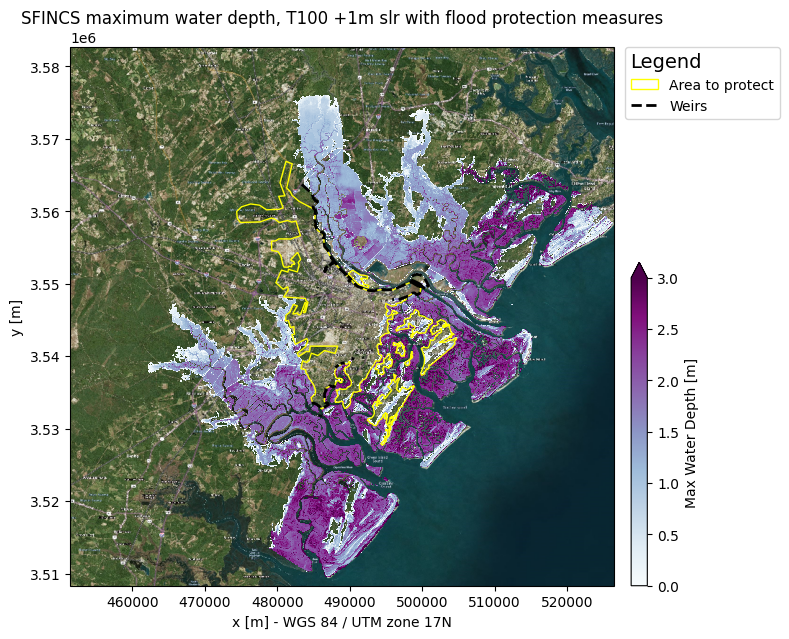

In [18]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# We use the subgrid resolution topography to downscale the maximum water level to water depth at the subgrid resolution
# First, we read the subgrid resolution topography and check if the file exists
dep_subgrid_file = Path(model_root_old, "subgrid", "dep_subgrid.tif")  
if not dep_subgrid_file.exists():
    raise FileNotFoundError(
        f"Subgrid resolution topography file not found: {dep_subgrid_file}. "
    )
dep_subgrid = hydromt.open_raster(dep_subgrid_file, nodata=np.nan) # elevation at subgrid resolution

# calculate the maximum water depth (hmax) as the difference between 
# the maximum water level (zsmax) and the elevation (dep)
zsmax = sf.results["zsmax"].max(dim="timemax") # maximum water level
zsmax_subgrid = zsmax.raster.reproject_like(dep_subgrid, method="nearest")  # reproject to subgrid resolution
hmax_subgrid = np.maximum(0, zsmax_subgrid - dep_subgrid).round(2).astype(np.float32) # maximum water depth
# Here, we assume that all areas with a negative depth are permanent water bodies
# This is a strong simplification. It is better to use a more sophisticated approach
# to identify permanent water bodies, e.g. based on a water mask or a "tide-only" simulation.
permament_water = dep_subgrid < 0 
hmax_subgrid = hmax_subgrid.where(~permament_water, np.nan) # mask areas with permanent water
# update (geospatial) metadata
hmax_subgrid.raster.set_crs(dep_subgrid.raster.crs)
hmax_subgrid.raster.set_nodata(np.nan)
hmax_subgrid.name = "max water depth"
hmax_subgrid.attrs["units"] = "m"

fig, ax = sf.plot_basemap(
    fn_out="hmax.png",  # save figure to mod.root/figs/hmax.png
    variable=hmax_subgrid,
    plot_bounds=False, plot_geoms=False,
    bmap="sat",
    zoomlevel=12,
    figsize=(11, 7),
    vmin=0,  # set minimum value for colorbar
    vmax=3,  # set maximum value for colorbar
    cmap="BuPu",    
    cbar_kwargs={
        "pad": 0.02,       # Heel dicht bij de kaart (standaard is vaak 0.05 of meer)
        "shrink": 0.6,     # Zelfde hoogte als de andere balk (voor symmetrie)
        "anchor": (0.0, 0.0),
        "label": "Max Water Depth [m]" # Label hier expliciet opgeven is vaak netter
    }
)

#Plot areas to protect
critical_areas_file = "../data_processed/Critical_areas.gpkg"
gdf_critical = gpd.read_file(critical_areas_file)

if gdf_critical.crs != hmax_subgrid.rio.crs:
    print(f"Reprojecting critical areas from {gdf_critical.crs.to_string()} to {hmax_subgrid.rio.crs.to_string()}")
    gdf_critical = gdf_critical.to_crs(hmax_subgrid.rio.crs)

fill_color_rgba = (1.0, 0.0, 1.0, 0.0)
edge_color_solid = "yellow" # Pas aan naar wens (bijv. ook 'magenta')

gdf_critical.plot(
    ax=ax,                      # Teken op dezelfde as
    facecolor=fill_color_rgba,  # De transparante magenta vulling
    edgecolor=edge_color_solid, # De massieve rand
    linewidth=1.0,              # Dikte van de rand
    # alpha=...                 # BELANGRIJK: Gebruik deze NIET, anders overschrijf je de RGBA instellingen hierboven
    zorder=15,                  # Zorg dat dit bovenop de waterlagen (die vaak zorder 1-10 hebben) ligt
    label="Areas to protect"                   
)

structures_file = "../data_processed/levees_and_weirs.geojson"
gdf_structures = gpd.read_file(structures_file)

# Check projectie
if gdf_structures.crs != hmax_subgrid.rio.crs:
    gdf_structures = gdf_structures.to_crs(hmax_subgrid.rio.crs)

gdf_structures.plot(
    ax=ax,
    color="black",      # Zwart voor de structuur
    linewidth=2.0,linestyle='--',      # Dikke lijn
    zorder=20           # Ligt BOVENOP de kritieke gebieden (die waren 15)
)

new_handle = mpatches.Patch(
    facecolor=(1.0, 0.0, 1.0, 0.0), 
    edgecolor='yellow', 
    linewidth=1.0, 
    label='Area to protect'
)

new_handle_2 = Line2D(
    [0], [0], 
    color='black', 
    linewidth=2.0,       # Dikte matcht met je plot
    linestyle='--',      # Streepjes matchen met je plot
    label='Weirs'
)


# 2. Haal de items op die er al stonden (vanuit plot_basemap of andere lagen)
# handles = de symbolen, labels = de tekst
handles, labels = ax.get_legend_handles_labels()

# 3. Voeg jouw nieuwe item toe aan de bestaande lijst
handles.append(new_handle)
handles.append(new_handle_2)
labels.append(new_handle.get_label())
labels.append(new_handle_2.get_label())

ax.legend(
    title="Legend", title_fontsize=14, alignment="left",
    handles=handles, 
    labels=labels, 
    loc='upper left',          # Welk punt van de legenda-box gebruiken we als anker? (Links-boven)
    bbox_to_anchor=(1.02, 1),  # Waar pinnen we dat punt vast? (X=1.02 is iets rechts van de kaart, Y=1 is bovenkant)
    borderaxespad=0,           # Geen extra witruimte tussen anker en box
    frameon=True               # Zet er een wit kader omheen (ziet er vaak netter uit buiten de kaart)
)

ax.set_title("SFINCS maximum water depth, T100 +1m slr with flood protection measures")

In [19]:
# save the results to a geotiff file
# round to 2 decimals to reduce file size

hmax_subgrid.raster.set_nodata(np.nan)
hmax_subgrid.round(2).raster.to_raster(
    Path(sf.root, f"hmax_slr{int(slr*100)}.tif"),
    compress="lzw",
    overwrite=True,
    dtype="float32",
)

Text(0.5, 1.0, 'Water Depth Difference Map: SLR (+1m) vs. Current T500v')

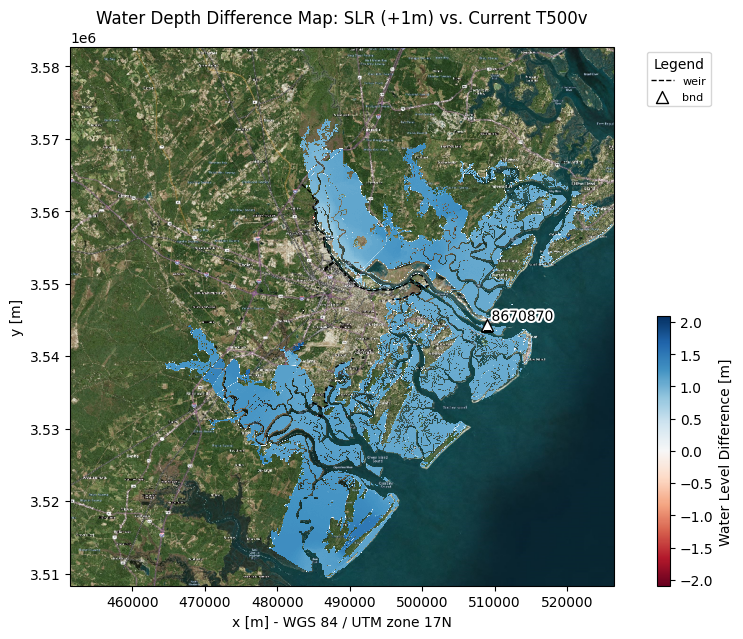

In [20]:
# load the original maximum water depth and create a difference map
# adapt and complete the code below

hmax_org_file = Path(model_root_old, "hmax.tif")
hmax_org = hydromt.open_raster(hmax_org_file)

diff_map = hmax_subgrid - hmax_org
diff_map.name = "Water Level Difference"
diff_map.attrs["long_name"] = "Water Level Difference"
diff_map.attrs["units"] = "m"

min_val = diff_map.min().compute().item()
max_val = diff_map.max().compute().item()

limit = max(abs(min_val), abs(max_val))

fig, ax = sf.plot_basemap(
        variable=diff_map,
        plot_bounds=False,
        bmap="sat",      # Achtergrondkaart
        zoomlevel=12,
        figsize=(11, 7),
        vmin=-limit,       # Minimumwaarde voor de kleurenbalk (pas aan indien nodig)
        vmax=limit,        # Maximumwaarde voor de kleurenbalk
        cmap="RdBu",     # Rood (afname) naar Blauw (toename)
        # levels=20
    )
    
    # Voeg een titel toe
ax.set_title(f"Water Depth Difference Map: SLR (+{slr}m) vs. Current T500v")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ... (jouw laad-code voor hmax_org en hmax_subgrid) ...

# --- STAP 1: Data Voorbereiden ---

# Aanname: '0' of 'NaN' betekent droog. We vervangen NaNs tijdelijk door 0 voor de vergelijking.
hmax_org_filled = hmax_org.fillna(0)
hmax_sub_filled = hmax_subgrid.fillna(0)

# Masker A: Gebieden die in BEIDE scenario's nat zijn (waar we het verschil willen zien)
mask_existing_wet = (hmax_org_filled > 0) & (hmax_sub_filled > 0)

# Masker B: Gebieden die EERST droog waren en NU nat zijn (nieuwe overstroming)
mask_newly_flooded = (hmax_org_filled == 0) & (hmax_sub_filled > 0)

# Creëer de twee datasets
# 1. Verschilkaart (alleen waar het al nat was)
diff_map_existing = (hmax_subgrid - hmax_org).where(mask_existing_wet)
diff_map_existing.name = "Water Level Difference"

# 2. Nieuw overstroomd (toon hier de nieuwe diepte)
newly_flooded_depth = hmax_subgrid.where(mask_newly_flooded)
newly_flooded_depth.name = "New Flood Depth"

# Bepaal limieten voor de RdBu schaal (alleen gebaseerd op het verschil in bestaande gebieden)
min_val = diff_map_existing.min().compute().item()
max_val = diff_map_existing.max().compute().item()
limit = max(abs(min_val), abs(max_val))

# --- STAP 2: Plotten ---

# Plot laag 1: Het verschil in bestaande gebieden (RdBu)
# We gebruiken jouw sf.plot_basemap functie als basis
fig, ax = sf.plot_basemap(
    variable=diff_map_existing,
    plot_bounds=False,
    bmap="sat",
    zoomlevel=12,
    figsize=(11, 7),
    vmin=-limit,
    vmax=limit,
    cmap="RdBu",
    alpha=0.9 # Iets transparantie zodat de basemap zichtbaar blijft
)

# Plot laag 2: De nieuwe overstromingen (Paars)
# We gebruiken de standaard xarray plot functie op dezelfde as (ax=ax)
# 'Purples' loopt van heel licht paars naar donkerpaars
# new_plot = newly_flooded_depth.plot(
#     ax=ax,
#     cmap="Oranges",
#     vmin=0,           # Start bij 0 meter
#     vmax=2.0,         # Of een logische max diepte voor nieuwe gebieden
#     add_colorbar=True,
#     cbar_kwargs={"label": "Maximum_water_level_newlt_flooded_area_[m]"},
#     alpha=0.8
# )

new_plot = newly_flooded_depth.plot(
    ax=ax,
    cmap="Oranges",
    vmin=0,
    vmax=2.0,
    add_colorbar=True,
    # Pas hier de grootte aan
    cbar_kwargs={
        "label": "Maximum_water_level_newly_flooded_area_[m]",
        "shrink": 0.5,      # Maak de balk kleiner (70% van de as-hoogte)
        "aspect": 20,       # Hoe 'dik' de balk is (hoger getal = dunner)
        "pad": 0.05,        # Afstand tot de plot/andere colorbar
        "anchor": (0.0, 0.0) # Centreer de balk verticaal
    },
    alpha=0.8
)
import geopandas as gpd
# import matplotlib.colors as mcolors # Eventueel nodig als je andere kleurnamen wilt omzetten

# 1. Laad het bestand
critical_areas_file = "../data_processed/Critical_areas.gpkg"
gdf_critical = gpd.read_file(critical_areas_file)

# 2. Zorg dat het coördinatenstelsel (CRS) matcht met je rasters
# Dit is essentieel voor een correcte overlap
if gdf_critical.crs != hmax_org.rio.crs:
    print(f"Reprojecting critical areas from {gdf_critical.crs.to_string()} to {hmax_org.rio.crs.to_string()}")
    gdf_critical = gdf_critical.to_crs(hmax_org.rio.crs)

# 3. Definieer de kleuren met specifieke transparantie (RGBA)

# Vulling: Magenta (Rood=1, Groen=0, Blauw=1) met Alpha=0.1
fill_color_rgba = (1.0, 0.0, 1.0, 0.0)

# Rand: Kies een kleur. Omdat je transparantie 1 wilt (volledig zichtbaar),
# kun je gewoon de naam gebruiken (bijv. 'red', 'black', 'magenta').
# Matplotlib gebruikt standaard alpha=1.0 als je een naam opgeeft.
edge_color_solid = "yellow" # Pas aan naar wens (bijv. ook 'magenta')

# 4. Plot de laag
gdf_critical.plot(
    ax=ax,                      # Teken op dezelfde as
    facecolor=fill_color_rgba,  # De transparante magenta vulling
    edgecolor=edge_color_solid, # De massieve rand
    linewidth=1.0,              # Dikte van de rand
    # alpha=...                 # BELANGRIJK: Gebruik deze NIET, anders overschrijf je de RGBA instellingen hierboven
    zorder=15,                  # Zorg dat dit bovenop de waterlagen (die vaak zorder 1-10 hebben) ligt
    label="Areas to protect"                   
)

from matplotlib.lines import Line2D # Nodig voor de legenda lijn

# --- STAP 1: Data Laden & Filteren ---

structures_file = "../data_processed/levees_and_weirs.geojson"
gdf_structures = gpd.read_file(structures_file)

# Check projectie
if gdf_structures.crs != hmax_org.rio.crs:
    gdf_structures = gdf_structures.to_crs(hmax_org.rio.crs)

# OPTIONEEL: Filteren
# Als het bestand dijken EN stuwen bevat, wil je misschien filteren.
# Kijk even in je data hoe de kolom heet (bijv. 'type', 'category', 'name').
# Voorbeeld (haal het hekje weg als je dit nodig hebt):
# gdf_weirs = gdf_structures[gdf_structures['type'] == 'weir'] 
# Gebruik hieronder dan 'gdf_weirs' in plaats van 'gdf_structures'

# --- STAP 2: Plotten met hoge zorder ---

gdf_structures.plot(
    ax=ax,
    color="black",      # Zwart voor de structuur
    linewidth=3.0,linestyle='--',      # Dikke lijn
    zorder=20           # Ligt BOVENOP de kritieke gebieden (die waren 15)
)

import matplotlib.patches as mpatches

# ... (na al je plots, maar voor plt.show) ...

# 1. Maak je nieuwe handmatige legenda-item
new_handle = mpatches.Patch(
    facecolor=(1.0, 0.0, 1.0, 0.0), 
    edgecolor='yellow', 
    linewidth=1.0, 
    label='Area to protect'
)

# 2. Haal de items op die er al stonden (vanuit plot_basemap of andere lagen)
# handles = de symbolen, labels = de tekst
handles, labels = ax.get_legend_handles_labels()

# 3. Voeg jouw nieuwe item toe aan de bestaande lijst
handles.append(new_handle)
labels.append(new_handle.get_label())

# # 4. Teken de legenda met de complete lijst
# ax.legend(
#     handles=handles, 
#     labels=labels, 
#     loc='upper right', 
#     framealpha=1.0
# )

ax.legend(
    title="Legend", title_fontsize=14, alignment="left",
    handles=handles, 
    labels=labels, 
    loc='upper left',          # Welk punt van de legenda-box gebruiken we als anker? (Links-boven)
    bbox_to_anchor=(1.02, 1),  # Waar pinnen we dat punt vast? (X=1.02 is iets rechts van de kaart, Y=1 is bovenkant)
    borderaxespad=0,           # Geen extra witruimte tussen anker en box
    frameon=True               # Zet er een wit kader omheen (ziet er vaak netter uit buiten de kaart)
)

# Zorg dat de plot getoond wordt (als dit het einde van je script is)
# plt.show()
ax.set_title(f"Water Depth Diff: Current T500 vs. SLR (+{slr}m)\n(Orange = New Inundation)")

plt.show()

# Exercise 5b: Adaptation measure scenario analysis

Implement the same for other scenario analyses, e.g. by implementing an adaptation measure such as a levee or floodwall.

You can do this by implementing a [weir structure](https://sfincs.readthedocs.io/en/latest/input_structures.html#weirs) in the model.

This is done by drawing a line geometry file in e.g. QGIS or geojson.io of the levee/floodwall location. Each line should have a height "z" attribute value which defines the crest height. The weir can then be added to the model using the HydroMT-SFINCS method [setup_structures()](https://deltares.github.io/hydromt_sfincs/stable/_generated/hydromt_sfincs.SfincsModel.setup_structures.html#hydromt_sfincs.SfincsModel.setup_structures)

We suggest you make a copy of the notebook and implement the changes there following the steps as above.